# Capítulo 2 – End-to-end Machine Learning project

# Indice

+ [Configuración](#Configuración)
 + [Carga de datos](#Carga-de-datos)
 + [Crear un conjunto de prueba](#Crear-un-conjunto-de-prueba)
+ [Descubrir y visualizar datos para obtener información (insights)](Descubrir-y-visualizar-datos-para-obtener-información)
 + [Visualización geográfica de datos](#Visualización-geográfica-de-datos)
 + [Buscando correlaciones](#Buscando-correlaciones)
 + [Experimentando con combinaciones de atributos](#Experimentando-con-combinaciones-de-atributos)
+ [Preparar los datos para algoritmos de machine learning](#Preparar-los-datos-para-algoritmos-de-machine-learning)
 + [Data cleaning](#Data-cleaning)
 + [Manejar texto y atributos categóricos](#Manejar-texto-y-atributos-categóricos)
 + [Transformadores personalizados](#Transformadores-personalizados)
 + [Escalado de características](#Escalado-de-características)
 + [Pipelines de transformación](#Pipelines-de-transformación)
+ [Seleccionar y entrenar un modelo](#Seleccionar-y-entrenar-un-modelo)
 + [Entrenamiento y evaluación del conjunto de entrenamiento](#Entrenamiento-y-evaluación-del-conjunto-de-entrenamiento)
+ [Afinar el modelo](#Afinar-el-modelo)
 + [Validación cruzada (cross validation)](#Validación-cruzada-(cross-validation))
 + [Grid Search](#Grid-Search)
 + [Randomized Search](#Randomized-Search)
 + [Analizar el mejor modelo y sus errores](#Analizar-el-mejor-modelo-y-sus-errores)
 + [Evaluar el sistema en el conjunto de prueba](#Evaluar-el-sistema-en-el-conjunto-de-prueba)
+ [Material extra](#Material-extra)
 + [Pipeline completo tanto de preparación como de predicción](#Pipeline-completo-tanto-de-preparación-como-de-predicción)
 + [Persistencia del modelo usando joblib](#Persistencia-del-modelo-usando-joblib)
+ [Ejercicios](#Ejercicios)
 + [Ej.1](#Ej.1)
 + [Ej.2](#Ej.2)
 + [Ej.3](#Ej.3)
 + [Ej.4](#Ej.4)
 + [Ej.5](#Ej.5)

# Configuración

In [1]:
# imports comunes
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

# Hacer las salidas de este notebook estables a través de ejecuciones
np.random.seed(42)

# Hacemos algunos ajustes a los gráficos
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Donde grabar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Grabando figura", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignorar warning inútiles (ver SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Carga de datos

In [2]:
def load_housing_data(housing_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data(os.path.join("data", "housing"))
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Hay distritos a los que les faltan algunos valores del atributo `total_bedrooms`, en concreto 207 de ellos. Comprobamos que todos los atributos son numéricos (float) excepto `ocean_proximity` que es de tipo `object` (contiene cadenas de texto). Echando un vistazo a las primera 5 files del dataframe comprobamos que este atributo tiene los valores repetidos, por lo que deducimos que se trata de una variable categórica. Veamos cuántas categorías existen y cuántos distritos pertenecen a cada categoría:

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe(include="object")

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Otra forma rápida de tener una idea del tipo de datos con los que estamos tratando es dibujar un Histograma para cada atributo numérico. Un histograma muestra el número de instancias. Podemos dibujar una atributo cada vez o podemos invocar al método hist() en el dataset completo, lo que dibujará un histograma para cada atributo numérico. 

Grabando figura attribute_histogram_plots


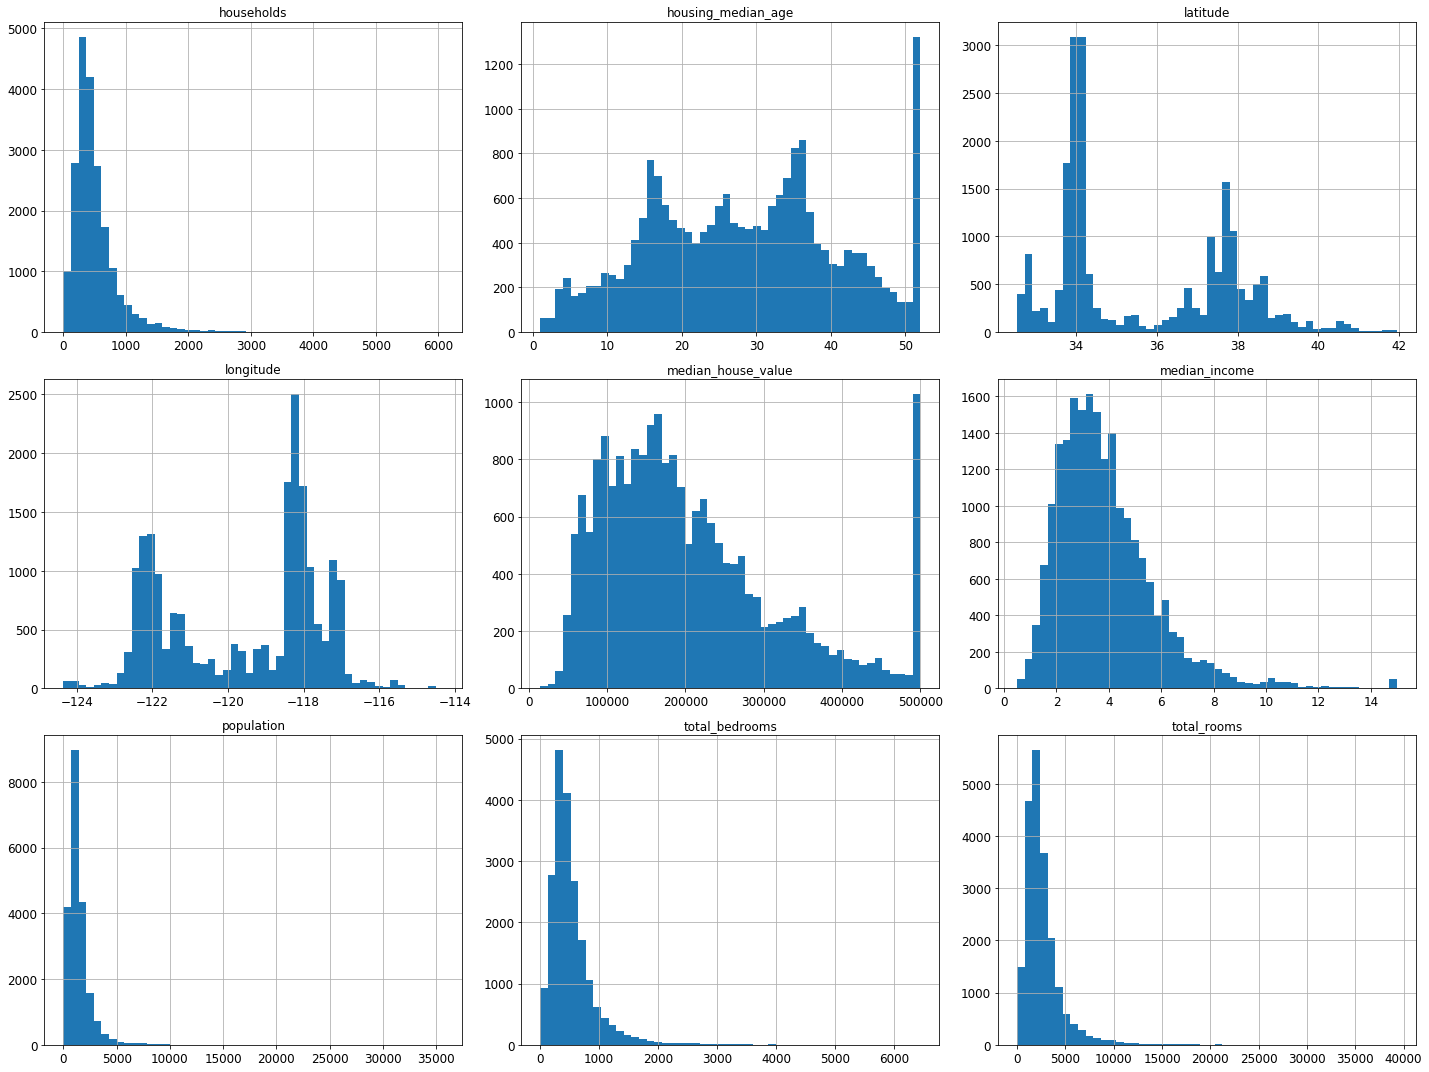

In [8]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Observamos que algunos atributos, como `median_income` no están expresados en en dólares (USD). Hablando con el equipo que recopiló los datos nos dicen que los datos fueron escalados y se limitaron a 15 (en realidad 15,001) para ingresos medios altos y en 0,5 (en realidad 0,4999) para ingresos medios bajos.

Otros atributos que se limitaros o caparon son `housing median age` y `median house value`. Es importante conocer cómo se han computado estos datos por que afectarán al algoritmo de machine learning que seleccionemos. Si el cliente final nos dice que sí es necesaria una precisión más allá de 500.000$ tenemos dos opciones:

+ Recopilar los distritos para los que se han "capado" este atributo.
+ Eliminarlos del conjunto de entrenamiento y de prueba, ya que nuestro sistema no debe evaluarse mal si predice valores más allá de 500.000$

Finalmente, muchos histogramas son de "cola pesada". Es decir, se extiende mucho más hacia la derecha de la mediana que hacia la izquierda. Esto puede complicar a los algoritmos de machine learning detectar patrones. Intentaremos transformar dichos atributos para obtener distribuciones más en forma de campana.

## Crear un conjunto de prueba

Crear un conjunto de pruebas es teóricamente bastante simple: elegimos instancias al azar, generalmente el 20% del conjunto de datos. Scikit-Learn proporciona algunas funciones para dividir conjuntos de datos en múltiples subconjuntos de varias maneras. La función más simple es `train_test_split`, que tiene las siguiente ventajas. Primero, hay un parámetro `random_state` que le permite establecer un generador aleatorio para poder reproducir los mismo resultados entre diferentes ejecuciones y, segundo, podemos pasarle múltiples conjuntos de datos con un número idéntico de filas y los dividirá en los mismos índices (esto es muy útil, por ejemplo, si tenemos un DataFrame separado para los *labels* (targets).

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [10]:
print("{} entrenamiento + {} prueba".format(train_set.shape[0], test_set.shape[0]))

16512 entrenamiento + 4128 prueba


In [11]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


Hasta ahora hemos considerado métodos de muestreo puramente aleatorios. Esto generalmente está bien si tu conjunto de datos es lo suficientemente grande (especialmente en relación con el número de atributos), pero si no es así, se corre el riesgo de introducir un sesgo de muestreo significativo. Cuando una empresa de encuestas decide llamar a 1.000 personas para hacerles algunas preguntas, no solo eligen 1.000 personas al azar en una cabina telefónica. Intentan asegurar que estas 1.000 personas son representativos de toda la población. Por ejemplo, la población de EE. UU. está compuesta por un 51,3% de mujeres y un 48,7% de hombres, por lo que una encuesta bien realizada trataría de mantener esta proporción en la muestra: 513 mujeres y 487 hombres. Esto se denomina *muestreo estratificado*: la población se divide en subgrupos homogéneos llamados *estratos* y se muestrea el número correcto de casos de cada estrato para garantizar que el conjunto de pruebas sea representativo de la población general.

Supongamos que hemos hablado con los expertos y nos dijeron que el ingreso medio es un atributo muy importante para predecir los precios promedio de las viviendas. Es posible que queramos asegurarnos de que el conjunto de pruebas sea representativo de las diversas categorías de ingresos en el conjunto de datos completo. Dado que el ingreso medio es un atributo numérico continuo, primero debe crear un atributo de categoría de ingreso. Veamos más de cerca el histograma de ingreso medio:

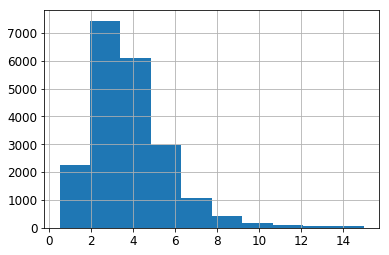

In [12]:
housing["median_income"].hist();

La mayoría de los valores de ingresos medios se agrupan alrededor de 2 a 5 (decenas de miles de dólares), pero algunos ingresos medios van mucho más allá de 6. Es importante tener un número suficiente de instancias en nuestro conjunto de datos para cada estrato, o si no la estimación de la importancia del estrato puede ser sesgada. Esto significa que no debemos tener demasiados estratos y cada estrato debe ser lo suficientemente grande. El siguiente código crea un atributo de categoría de ingreso al dividir el ingreso medio por 1.5 (para limitar el número de categorías de ingreso), y redondear usando `ceil` (para tener categorías discretas) y luego fusionar todas las categorías superiores a 5 en la categoría 5:

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

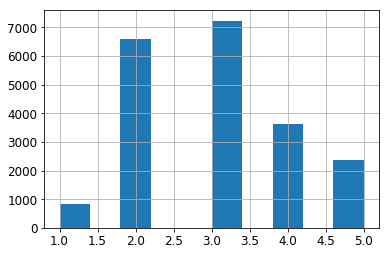

In [14]:
housing["income_cat"].hist();

Ahora ya podemos hacer muestreo estratificado basado en la categoría ingresos

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Vamos a mostrar la proporción de cada categoría para comprobar si estratifica correctamente

In [16]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Vamos a comparar la proporción de la categoría ingresos en el dataset global, en el conjunto de pruebas con muestreo estratificado y en el conjunto de pruebas usando muestreo aleatorio puro.

In [18]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Global": income_cat_proportions(housing),
    "Estratificado": income_cat_proportions(strat_test_set),
    "Aleatorio": income_cat_proportions(test_set),
}).sort_index()
compare_props["Aleatorio %error"] = 100 * compare_props["Aleatorio"] / compare_props["Global"] - 100
compare_props["Estratificado %error"] = 100 * compare_props["Estratificado"] / compare_props["Global"] - 100

compare_props

,Global,Estratificado,Aleatorio,Aleatorio %error,Estratificado %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Podemos comprobar que el conjunto de pruebas usando muestreo estratificado tiene casi las mismas proporciones que el conjunto global.

Ahora eliminamos el atributo `income_cat` para devolver el dataset a su estado original.

In [19]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Descubrir y visualizar datos para obtener información (insights)

En primer lugar vamos a crear una copia para que podamos jugar sin dañar el conjunto de entrenamiento:

In [20]:
housing = strat_train_set.copy()

## Visualización geográfica de datos

Grabando figura bad_visualization_plot


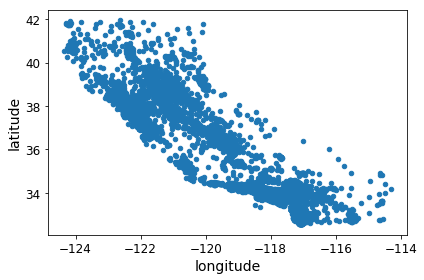

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Parece California, ¿no? Pero reulta complicado detectar patrones. Estableciendo la opción `alpha` a `0.1` resulta mucho más fácil visualizar los sitios donde existe una alta densidad de puntos:

Grabando figura better_visualization_plot


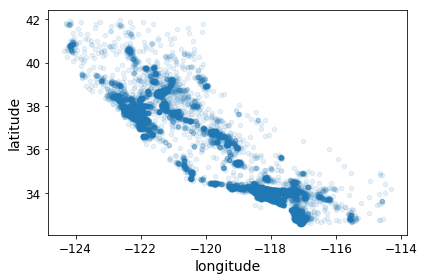

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

De manera más general, nuestros cerebros son muy buenos para detectar patrones en las imágenes, pero es posible que debamos jugar con los parámetros de visualización para que los patrones se destaquen.

Grabando figura housing_prices_scatterplot


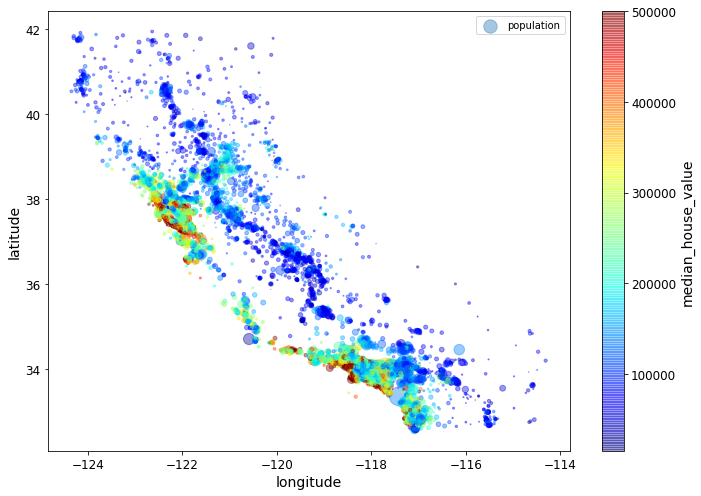

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

El radio de cada círculo representa la población del distrito (opción `s`) y el color representa el precio (opción `c`). Usaremos un mapa de color predefinido (opción `cmap`) llamado `jet`, cuyo rango va del azul (precios bajos) al rojo (precios altos).

Esta imagen nos dice que los precios de la vivienda están muy relacionados con la ubicación (por ejemplo, cerca del océano) y con la densidad de población, como probablemente ya sabíamos. Probablemente será útil utilizar un algoritmo de agrupación en clústeres para detectar los clústeres principales y agregar nuevas funciones que midan la proximidad a los centros de los clústeres. El atributo de proximidad al océano también puede ser útil, aunque en el norte de California los precios de las viviendas en los distritos costeros no son demasiado altos, por lo que no es una regla simple.

Grabando figura california_housing_prices_plot


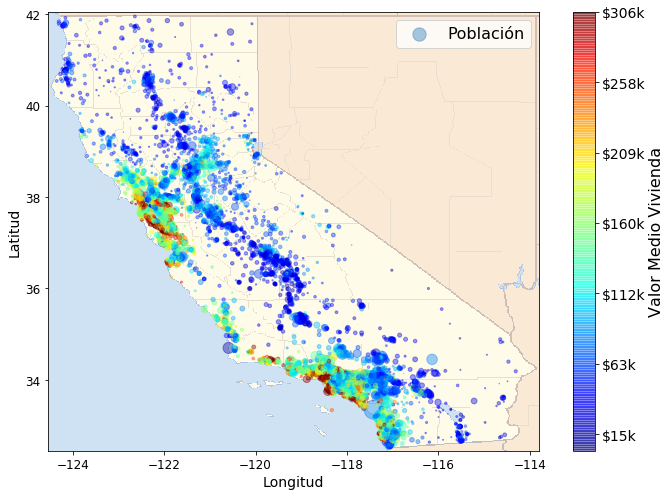

In [24]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Población",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitud", fontsize=14)
plt.xlabel("Longitud", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Valor Medio Vivienda', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

## Buscando correlaciones

Dado que el dataset no es muy grande podemos calcular fácilmente el *coeficiente de correlación estándar* (tmabién denominado *r de Pearson*) entre pares haciendo uso del método `corr()`.

In [25]:
corr_matrix = housing.corr()

# Veamos cuáles son las correlaciones de cada atributo con el valor medio de la vivienda
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

El coeficiente de correlación oscila entre –1 y 1. Cuando está cerca de 1, significa que existe una fuerte correlación positiva; por ejemplo, el valor medio de la vivienda tiende a subir cuando el ingreso medio aumenta. Cuando el coeficiente está cerca de -1, significa que existe una fuerte correlación negativa. Puede verse una pequeña correlación negativa entre la latitud y el valor medio de la casa (es decir, los precios tienen una ligera tendencia a bajar cuando se va al norte). Finalmente, los coeficientes cercanos a cero significan que no hay una correlación lineal. A continuación se muestran varios gráficos junto con el coeficiente de correlación entre sus ejes horizontal y vertical.

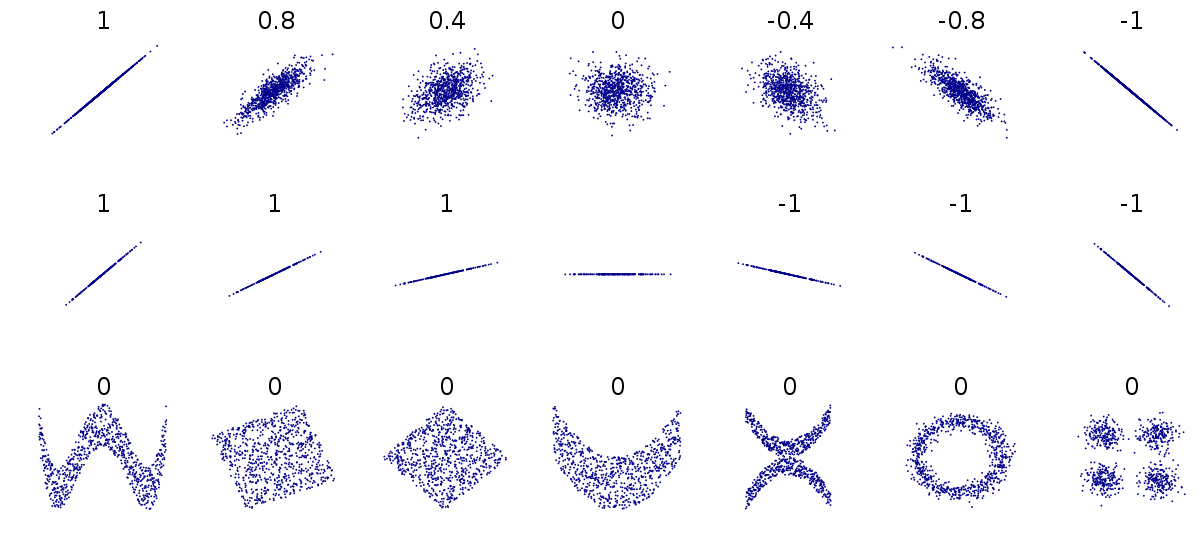

In [26]:
from IPython.display import Image
Image(filename="./images/end_to_end_project/Correlation_examples.png")

El coeficiente de correlación solo mide las correlaciones lineales ("si `x` sube entonces `y` generalmente sube / baja"). Es posible que se pierda completamente las relaciones no lineales (por ejemplo, "si `x` está cerca de cero, entonces `y` generalmente aumenta"). Observemos cómo todas las gráficas de la fila inferior tienen un coeficiente de correlación igual a cero, a pesar del hecho de que sus ejes claramente no son independientes: estos son ejemplos de relaciones no lineales. Además, la segunda fila muestra ejemplos en los que el coeficiente de correlación es igual a 1 o –1: esto no tiene nada que ver con la pendiente. Por ejemplo, nuestra altura en pulgadas tiene un coeficiente de correlación de 1 con nuestra altura en pies o en nanómetros.

Otra forma de verificar la correlación entre atributos es usar la función `scatter_matrix` de Pandas, que dibuja cada atributo numérico contra cada otro atributo numérico.

Grabando figura scatter_matrix_plot


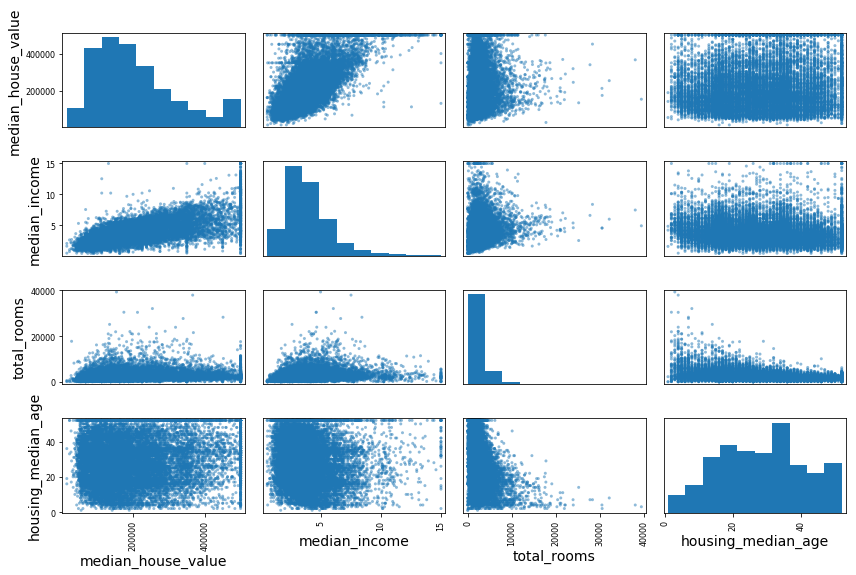

In [27]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

El atributo más prometedor para predecir el valor medio de la vivienda es el ingreso medio, así que hagamos zoom en su diagrama de dispersión:

Grabando figura income_vs_house_value_scatterplot


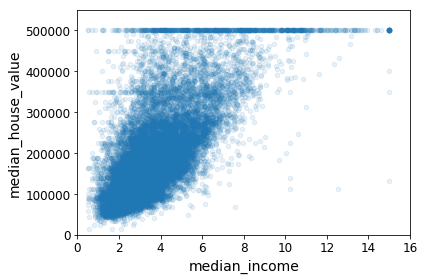

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

Detectamos varias cosas en este gráfico. Primero, la correlación es de hecho muy fuerte; Se puede ver claramente la tendencia alcista y que los puntos no están muy dispersos. Segundo, el límite de precio que notamos anteriormente es claramente visible como una línea horizontal a 500.000. Pero esta gráfica revela otras líneas rectas menos obvias: una línea horizontal alrededor de 450.000, otra alrededor de 350.000, tal vez una alrededor de 280.000, y algunas más por debajo de eso. Puede intentar eliminar los distritos correspondientes para evitar que sus algoritmos aprendan a reproducir estas peculiaridades de los datos.

## Experimentando con combinaciones de atributos

Una última cosa que podemos hacer antes de preparar realmente los datos para los algoritmos de machine learning es probar varias combinaciones de atributos. Por ejemplo, el número total de habitaciones en un distrito no es muy útil si no sabe cuántos hogares hay. Lo que realmente queremos es el número de habitaciones por hogar. Del mismo modo, el número total de habitaciones por sí solo no es muy útil: probablemente queramos compararla con la cantidad de habitaciones. Y la población por hogar también parece ser una combinación de atributos interesante a considerar. Vamos a crear estos nuevos atributos.

In [29]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [30]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

El nuevo atributo `bedrooms_per_room` está mucho más relacionado con el valor medio de la casa que el número total de habitaciones o dormitorios. Al parecer, las casas con una proporción más baja de habitación / habitación tienden a ser más caras. La cantidad de habitaciones por hogar (`rooms_per_household`) también es más informativa que la cantidad total de habitaciones en un distrito; obviamente, cuanto más grandes son las casas, más caras son. Esta ronda de exploración no tiene que ser absolutamente exhaustiva; el punto es comenzar con el pie derecho y obtener rápidamente conocimientos que nos ayudarán a obtener un primer prototipo razonablemente bueno. Pero este es un proceso iterativo: una vez que se pone en marcha un prototipo, puede analizar su salida para obtener más información y volver a este paso de exploración.

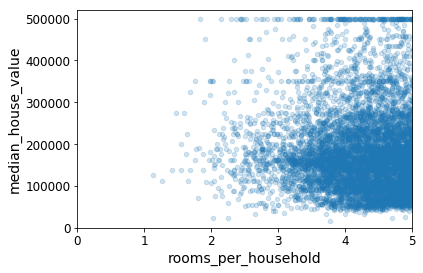

In [31]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [32]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Preparar los datos para algoritmos de machine learning

In [33]:
# Vamos a utilizar una copia limpia de los datos
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data cleaning

La mayoría de los algoritmos de machine learning no pueden funcionar con las características con valores faltantes, por lo que vamos a crear algunas funciones para solucionarlo. Anteriormente, vimos que el atributo `total_bedrooms` tiene algunos valores faltantes, así que vamos a arreglar esto. Tenemos tres opciones:

+ Deshacerse de los distritos correspondientes.
+ Deshacerse de todo el atributo.
+ Establecer los valores en algún valor (cero, la media, la mediana, etc.).

In [34]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [35]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # opción 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [36]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # opción 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [37]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # opcion 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


Scikit-Learn proporciona una clase para completar los valores faltantes: `SimpleImputer`. Así es como se usa: primero creamos una instancia de `SimpleImputer`, especificando que deseamos reemplazar los valores faltantes de cada atributo con la mediana de ese atributo:

In [38]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Dado que la mediana solo se puede calcular en atributos numéricos, debemos crear una copia de los datos sin el atributo de texto `ocean_proximity`:

In [39]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [40]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

`imputer` simplemente calculó la mediana de cada atributo y almacenó el resultado en su variable de instancia `statistics_`

In [41]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Vamos a verificar que esto sea lo mismo que calcular manualmente la mediana de cada atributo:

In [42]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Una vez que hemos "entrenado" `imputer`transformamos el conjunto de entrenamiento reemplazando los valores faltantes por las medias obtenidas:

In [43]:
X = imputer.transform(housing_num)

El resultado es una array Numpy conteniendo las características transformadas. Si queremos convertirlo a dataframe de pandas:

In [44]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [45]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [46]:
imputer.strategy

'median'

In [47]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## Manejar texto y atributos categóricos

La mayoría de los algoritmos de machine learning prefieren trabajar con números, así que vamos a convertir estas etiquetas de texto a números.

In [48]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [49]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [50]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Un problema con esta representación es que los algoritmos ML supondrán que dos valores cercanos son más similares que dos valores distantes. Obviamente, este no es el caso (por ejemplo, las categorías 0 y 4 son más similares a las categorías 0 y 1). Para solucionar este problema, una solución común es crear un atributo binario por categoría: un atributo igual a 1 cuando la categoría es "<1 H OCEAN" (y 0 en caso contrario), otro atributo igual a 1 cuando la categoría es "INLAND" (y 0 en caso contrario), y así sucesivamente. Esto se denomina codificación en caliente (*one-hot encoding*), porque solo un atributo será igual a 1 (caliente), mientras que los otros serán 0 (frío).

In [51]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Por defecto, la clase `OneHotEncoder` devuelve una matriz dispersa, pero podemos convertirla en una matriz densa si es necesario llamando al método `toarray()`:

In [52]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternativamente, puede establecer `sparse = False` al crear `OneHotEncoder`:

In [53]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [54]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Transformadores personalizados

Aunque Scikit-Learn proporciona muchos transformadores útiles, tendremos que escribir los nuestros para tareas como las operaciones de limpieza personalizadas o la combinación de atributos específicos.

In [55]:
from sklearn.preprocessing import FunctionTransformer

# obtiene los índides de columnas correctos
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

En este ejemplo, el transformador tiene un hiperparámetro, `add_bedrooms_per_room`, establecido en True por defecto (a menudo es útil proporcionar valores predeterminados razonables). Este hiperparámetro le permitirá descubrir fácilmente si agregar este atributo ayuda a los algoritmos de aprendizaje automático o no. De manera más general, puede agregar un hiperparámetro para controlar cualquier paso de preparación de datos sobre el que no esté seguro al 100%. Cuanto más automatice estos pasos de preparación de datos, más combinaciones podrá probar automáticamente, por lo que es mucho más probable que encuentre una gran combinación (y le ahorre mucho tiempo).

In [56]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## Escalado de características

Una de las transformaciones más importantes que debe aplicar a sus datos es el escalado de características (*feature scaling*). Con pocas excepciones, los algoritmos de machine learning no funcionan bien cuando los atributos numéricos de entrada tienen escalas muy diferentes. Este es el caso de los datos de viviendas: el número total de habitaciones varía de aproximadamente 6 a 39.320, mientras que los ingresos medios solo varían de 0 a 15. Tenga en cuenta que generalmente no es necesario escalar los valores objetivo.

Hay dos formas habituales de hacer que todos los atributos tengan la misma escala: escalado mínimo-máximo (*min-max scaling*) y *estandarización*.

El escalado mínimo-máximo (también llamdo *normalización*) es bastante simple: los valores se cambian y se vuelven a escalar para que terminen en un rango de 0 a 1. Lo hacemos restando el valor mínimo y dividiendo por el máximo menos el mínimo. Scikit-Learn proporciona un transformador llamado `MinMaxScaler` para esto. Tiene un hiperparámetro `feature_range` que nos permite cambiar el rango si no queremos 0–1 por alguna razón.

La estandarización es bastante diferente: primero resta el valor medio (por lo tanto, los valores estandarizados siempre tienen un promedio cero) y luego se divide por la varianza, de modo que la distribución resultante tiene una varianza unitaria. A diferencia del escalado mínimo-máximo, la estandarización no limita los valores a un rango específico, lo que puede ser un problema para algunos algoritmos (por ejemplo, las redes neuronales a menudo esperan un valor de entrada que oscila entre 0 y 1). Sin embargo, la estandarización se ve mucho menos afectada por los valores atípicos. Por ejemplo, supongamos que un distrito tenía un ingreso medio igual a 100 (por error). El escalado mínimo-máximo comprimirá todos los demás valores desde 0-15 a 0-0,15, mientras que la estandarización no se vería muy afectada. Scikit-Learn proporciona un transformador llamado `StandardScaler` para la estandarización.

Al igual que con todas las transformaciones, **es importante ajustar los escaladores solo a los datos de entrenamiento**, no al conjunto de datos completo (incluido el conjunto de pruebas). Solo entonces podemos usarlos para transformar el conjunto de entrenamiento y el conjunto de prueba (y los nuevos datos).

## Pipelines de transformación

Como podemos ver, hay muchos pasos de transformación de datos que deben ejecutarse en el orden correcto. Afortunadamente, Scikit-Learn proporciona la clase `Pipeline` para ayudar con tales secuencias de transformaciones. A continuación veremos un pequeño pipeline para los atributos numéricos:

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [58]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Ahora tenemos un pipeline para valores numéricos y también necesitamos aplicar una transformación a los valores categóricos: ¿cómo podemos unir estas transformaciones en un solo pipeline? Scikit-Learn proporciona la clase `ColumnTransformer` para esto.

In [59]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [60]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [61]:
housing_prepared.shape

(16512, 16)

# Seleccionar y entrenar un modelo

## Entrenamiento y evaluación del conjunto de entrenamiento

En primer lugar, vamos a entrenar un modelo de regresión lineal.

In [62]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

¡Hecho! Ya tenemos un modelo de regresión lineal en funcionamiento. Probemos en algunos casos del conjunto de entrenamiento:

In [63]:
# vamos a probar el pipeline completo de preprocesamiento en algunas instancias de entrenamiento
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predicciones:", lin_reg.predict(some_data_prepared))

Predicciones: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Comparémoslas con los valores reales:

In [64]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [65]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

Funciona, aunque las predicciones no son exactamente precisas (por ejemplo, la segunda predicción está desviada en más del 50%). Midamos el RMSE de este modelo de regresión en todo el conjunto de entrenamiento utilizando la función `mean_squared_error` de Scikit-Learn:

In [66]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [67]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.895990018966

De acuerdo, esto es mejor que nada, pero claramente no es una gran puntuación: la mayoría de los `median_housing_values` de los distritos tienen un rango de valores entre 120.000 y 265.000, por lo que un error típico de predicción de 68.628 no es muy satisfactorio. Este es un ejemplo de un modelo que se sobreajusta (overfitting) a los datos de entrenamiento. Cuando esto sucede, puede significar que las características no proporcionan suficiente información para hacer buenas predicciones o que el modelo no es lo suficientemente poderoso. Como vimos anteriormente, las formas principales de solucionar el overfitting son seleccionar un modelo más potente, alimentar el algoritmo de entrenamiento con mejores características o reducir las restricciones en el modelo. Este modelo no está regularizado, por lo que descartamos la última opción. Podemos intentar agregar más funciones (por ejemplo, el registro de la población), pero primero probemos un modelo más complejo para ver cómo funciona.

Entrenemos un `DecisionTreeRegressor`. Este es un modelo poderoso, capaz de encontrar relaciones complejas no lineales en los datos:

In [68]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [69]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

¿Ningún error en absoluto? ¿Podría este modelo realmente ser absolutamente perfecto? Por supuesto, es mucho más probable que el modelo haya sobrecargado los datos gravemente. ¿Como podemos estar seguros? Como vimos anteriormente, no querremos tocar el conjunto de pruebas hasta que estemos listos para lanzar un modelo en el que tengamos confianza, por lo que necesitamos usar parte del conjunto de entrenamiento para entrenar y otra parte para la validación de modelos.

# Afinar el modelo

## Validación cruzada (cross validation)

Una forma de evaluar el modelo de Árbol de Decisiones sería utilizar la función `train_test_split` para dividir el conjunto de entrenamiento en un conjunto de entrenamiento más pequeño y un conjunto de validación, luego entrenar a sus modelos contra el conjunto de entrenamiento más pequeño y evaluarlos contra el conjunto de validación. Es un poco de trabajo, pero nada demasiado difícil y funcionaría bastante bien.

Una excelente alternativa es utilizar la función *cross-validation* de Scikit-Learn. El siguiente código realiza *K-fold cross-validation*: divide aleatoriamente el conjunto de entrenamiento en 10 subconjuntos diferentes llamados *folds*, luego entrena y evalúa el modelo del Árbol de Decisiones 10 veces, seleccionando un fold diferente cada vez para la evaluación y el entrenamiento en los otros 9 folds. El resultado es una matriz que contiene las 10 puntuaciones de evaluación:

In [70]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [71]:
def display_scores(scores):
    print("Puntuación:", scores)
    print("Media:", scores.mean())
    print("Desviación estándar:", scores.std())

display_scores(tree_rmse_scores)

Puntuación: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Media: 71407.68766037929
Desviación estándar: 2439.4345041191004


Ahora el Árbol de Decisiones no se ve tan bien como antes. De hecho, parece funcionar peor que el modelo de Regresión Lineal. Tengamos en cuenta que la validación cruzada nos permite obtener no solo una estimación del rendimiento de nuestro modelo, sino también una medida de cuán precisa es esta estimación (es decir, su desviación estándar). El Árbol de Decisiones tiene una puntuación de aproximadamente 71.400 ± 2.440. No tendríamos esta información si solo utilizaramos un conjunto de validación. Pero la validación cruzada tiene el costo de entrenar el modelo varias veces, por lo que no siempre es posible.

Vamos a calcular las mismas puntuaciones para el modelo de Regresión Lineal solo para estar seguros:

In [72]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Puntuación: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Media: 69052.46136345083
Desviación estándar: 2731.6740017983434


El modelo de Árbol de Decisión está tan gravemente sobreajustado que funciona peor que el modelo de Regresión Lineal.

Probemos ahora un último modelo: `RandomForestRegressor`. Los Bosques aleatorios trabajan entrenando muchos Árboles de Decisión en subconjuntos aleatorios de características y luego promedian sus predicciones. Construir un modelo sobre muchos otros modelos se denomina *Ensemble Learning* y, a menudo, es una excelente manera de impulsar aún más los algoritmos de machine learning.

In [73]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [74]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [75]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Puntuación: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Media: 52583.72407377466
Desviación estándar: 2298.353351147122


In [76]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

Esto es mucho mejor: los Bosques Aleatorios parecen muy prometedores. Sin embargo, tengamos en cuenta que la puntuación en el conjunto de entrenamiento es mucho más baja que en los conjuntos de validación, lo que significa que el modelo aún está sobreajusado al conjunto de entrenamiento. Las posibles soluciones a este overfitting son simplificar el modelo, restringirlo (es decir, regularizarlo) u obtener muchos más datos de entrenamiento. Sin embargo, antes de sumergirnos mucho más en Bosques Aleatorios, debemos probar muchos otros modelos de varias categorías de algoritmos de machine learning (varios Support Vector Machines con diferentes núcleos, posiblemente una red neuronal, etc.), sin pasar demasiado tiempo ajustando hiperparametros El objetivo es hacer una lista corta de algunos (dos a cinco) modelos prometedores.

## Grid Search

Una forma de afinar los modelos sería jugar manualmente con los hiperparámetros hasta que encuentremos una buena combinación de valores de hiperparámetros. Esto sería un trabajo muy tedioso y es posible que no tengamos tiempo para explorar muchas combinaciones. 

En su lugar, haremos que `GridSearchCV` de Scikit-Learn busque por nosotros. Todo lo que necesitamos hacer es decirle con qué hiperparámetros deseamos que experimente y qué valores probar, y evaluará todas las combinaciones posibles de valores de hiperparámetro mediante validación cruzada. Por ejemplo, el siguiente código busca la mejor combinación de valores de hiperparámetro para `RandomForestRegressor`:

In [77]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # probamos 12 (3×4) combinaciones de hiperparámetros
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # después probamos 6 (2×3) combinaciones con bootstrap establecido a False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# entrena a través de 5 folds, que suponen un total de (12+6)*5=90 rondas de entrenamiento
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Cuando no tenemos idea de qué valor debería tener un hiperparámetro, un enfoque simple es probar potencias consecutivas de 10 (o un número menor si desea una búsqueda más detallada, como se muestra en este ejemplo con el hiperparámetro `n_estimators`).

La mejor combinación de hiperparámetros encontrada:

In [78]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

Dado que 30 es el valor máximo de `n_estimators` que se evaluó, probablemente deberíamos evaluar valores más altos también ya que la puntuación puede continuar mejorando.

In [79]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Si `GridSearchCV` se inicializa con `refit = True` (que es el valor predeterminado), una vez que encuentra el mejor estimador utilizando la validación cruzada, lo vuelve a capacitar en todo el conjunto de entrenamiento. Esta suele ser una buena idea ya que proporcionarle más datos probablemente mejorará su rendimiento.

Veamos la puntuación de cada combinación de hiperparámetro probada durante grid search:

In [80]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

El puntaje RMSE para esta combinación es 49.682 que es ligeramente mayor que el puntaje que obtuvimos al usar los valores predeterminados de hiperparámetro (que fue 52.583). ¡Enhorabuena, hemos afinado con éxito nuestro mejor modelo!

Veamos todos los resultados juntos:

In [81]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.055236,0.000745,0.002800,0.000400,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.178332,0.002035,0.008035,0.000040,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.540438,0.003847,0.022027,0.000012,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.090839,0.001169,0.002600,0.000490,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.297070,0.002708,0.008016,0.000015,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.882375,0.001161,0.022590,0.000565,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537877e+09,1.214603e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.122274,0.003395,0.002829,0.000417,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441447e+09,1.893141e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.405983,0.003362,0.007827,0.000416,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704640e+09,1.471542e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.230307,0.005718,0.022242,0.000397,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514668e+09,1.285063e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.155419,0.000788,0.003002,0.000011,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348851e+09,1.241864e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


## Randomized Search

El enfoque de Grid Search está bien cuando estamos explorando relativamente pocas combinaciones, como en el ejemplo anterior, pero cuando el *espacio de búsqueda* del hiperparámetro es grande a menudo es preferible usar `RandomizedSearchCV` en su lugar. Esta clase se puede usar de la misma manera que la clase `GridSearchCV`, pero en lugar de probar todas las combinaciones posibles, evalúa un número dado de combinaciones aleatorias seleccionando un valor aleatorio para cada hiperparámetro en cada iteración. Este enfoque tiene dos beneficios principales:

+ Si deja que la búsqueda aleatoria se ejecute, digamos, 1.000 iteraciones, este enfoque explorará 1.000 valores diferentes para cada hiperparámetro (en lugar de unos pocos valores por hiperparámetro con el enfoque de grid search).
+ Tenemos más control sobre la carga de computación que desea asignar a la búsqueda de hiperparámetros, simplemente configurando el número de iteraciones.

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002AF806CC208>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002AF806CC358>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [84]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


In [85]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

## Analizar el mejor modelo y sus errores

Con frecuencia, obtendremos una buena visión del problema al inspeccionar los mejores modelos. Por ejemplo, `RandomForestRegressor` puede indicar la importancia relativa de cada atributo para hacer predicciones precisas:

In [86]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

Mostremos estas puntuaciones de importancia junto a sus nombres de atributos correspondientes:

In [87]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

## Evaluar el sistema en el conjunto de prueba

Después de ajustar nuestros modelos por un tiempo, finalmente tenemos un sistema que funciona suficientemente bien. Ahora es el momento de evaluar el modelo final en el conjunto de prueba. No hay nada especial en este proceso: simplemente obtenemos los predictores y las etiquetas del conjunto de prueba, ejecutamos nuestro `full_pipeline` para transformar los datos (`transform()`, **no** `fit_transform)`), y evaluamos el modelo final en el conjunto de prueba:

In [90]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [91]:
final_rmse

47730.22690385927

Podemos calcular un intervalo de confianza del 95% para la prueba RMSE:

In [92]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

Podríamos calcular el intervalo manualmente de esta manera:

In [93]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

Alternativamente, podríamos usar z-score en lugar de una t-score:

In [94]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

Por lo general, el rendimiento será un poco peor de lo que medimos con la validación cruzada si realizamos una gran cantidad de ajuste de hiperparámetros (porque nuestro sistema termina con un ajuste fino para obtener un buen rendimiento en los datos de validación y es probable que no funcione tan bien en conjuntos de datos desconocidos). No es el caso en este ejemplo, pero cuando esto sucede, debemos resistir la tentación de modificar los hiperparámetros para que los números se vean bien en el conjunto de pruebas; Es poco probable que las mejoras se generalicen a nuevos datos.

# Material extra

## Pipeline completo tanto de preparación como de predicción

In [88]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## Persistencia del modelo usando joblib

Deberíamos guardar todos los modelos con los que experimentemos para poder volver fácilmente a cualquiera de ellos cuando queramos. Asegurémonos de guardar tanto los hiperparámetros como los parámetros entrenados, así como las puntuaciones de validación cruzada y quizás también las predicciones reales. Esto nos permitirá comparar fácilmente las puntuaciones entre los tipos de modelos y comparar los tipos de errores que cometen. Podemos guardar fácilmente modelos Scikit-Learn utilizando el módulo `pickle` de Python, o usando `sklearn.externals.joblib`, que es más eficiente para serializar grandes arrays NumPy:

In [89]:
from sklearn.externals import joblib

my_model = full_pipeline_with_predictor

joblib.dump(my_model, os.path.join("data", "my_model.pkl")) # DIFF
#...
my_model_loaded = joblib.load(os.path.join("data", "my_model.pkl")) # DIFF

# Ejercicios
## Ej.1

**Pruebe un regresor Support Vector Machine (`sklearn.svm.SVR`), con varios hiperparámetros como `kernel = "linear"` (con varios valores para el hiperparámetro `C`) o `kernel = "rbf"` (con varios valores para los hiperparámetros `C` y `gamma`) . No nos preocupemos por lo que significan estos hiperparámetros por ahora. ¿Cómo funciona el mejor predictor de `SVR`?**

In [110]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   40.1s
c:\program files\python37\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 11.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

El mejor modelo alcanza la siguiente puntuación (usando 5-fold cross validation)

In [111]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.90313964167

Podemos concluir que es mucho peor que `RandomForestRegressor`

In [112]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

In [113]:
# Veamos todas las puntuaciones
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

84654.0893002138 {'C': 10.0, 'kernel': 'linear'}
75448.84743960595 {'C': 30.0, 'kernel': 'linear'}
71603.12196479437 {'C': 100.0, 'kernel': 'linear'}
70703.95891598675 {'C': 300.0, 'kernel': 'linear'}
70445.41077712944 {'C': 1000.0, 'kernel': 'linear'}
70395.09385716528 {'C': 3000.0, 'kernel': 'linear'}
70374.82796803635 {'C': 10000.0, 'kernel': 'linear'}
70363.90313964167 {'C': 30000.0, 'kernel': 'linear'}
118810.1205690511 {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
118692.80532644158 {'C': 1.0, 'gamma': 0.03, 'kernel': 'rbf'}
118637.95452846108 {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
118768.15436248068 {'C': 1.0, 'gamma': 0.3, 'kernel': 'rbf'}
118886.40095734302 {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
118916.0277544163 {'C': 1.0, 'gamma': 3.0, 'kernel': 'rbf'}
118595.98158948794 {'C': 3.0, 'gamma': 0.01, 'kernel': 'rbf'}
118256.35740976273 {'C': 3.0, 'gamma': 0.03, 'kernel': 'rbf'}
118077.6821796029 {'C': 3.0, 'gamma': 0.1, 'kernel': 'rbf'}
118460.72108108265 {'C': 3.0, 'gamma': 

El kernel `linear` parece mejor que el kernel `RBF`. Observe que el valor de C es el valor máximo probado. Cuando esto suceda, definitivamente deberíamos iniciar grid search nuevamente con valores más altos para C (eliminando los valores más pequeños), porque es probable que los valores más altos de C sean mejores. Vamos a probarlo:

In [115]:
param_grid = [
        {'kernel': ['linear'], 'C': [30000.0, 40000.0, 60000.0, 80000.0, 100000.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
c:\program files\python37\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [30000.0, 40000.0, 60000.0, 80000.0, 100000.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [116]:
grid_search.best_params_

{'C': 100000.0, 'kernel': 'linear'}

In [117]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70352.61867210406

In [118]:
# Veamos todas las puntuaciones
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

70363.90313964167 {'C': 30000.0, 'kernel': 'linear'}
70360.7215771535 {'C': 40000.0, 'kernel': 'linear'}
70358.65614927896 {'C': 60000.0, 'kernel': 'linear'}
70353.50326466672 {'C': 80000.0, 'kernel': 'linear'}
70352.61867210406 {'C': 100000.0, 'kernel': 'linear'}


## Ej.2

**Prueba a reemplazar `GridSearchCV` por `RandomizedSearchCV`**

In [121]:
from scipy.stats import expon, reciprocal

param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=16, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   40.7s
c:\program files\python37\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  5.6min
[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed: 11.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=16,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002AF806BB0B8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002AF806BBD68>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [123]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.99053704408

Ahora esto está mucho más cerca del rendimiento de `RandomForestRegressor` (pero todavía no ha llegado). Veamos los mejores hiperparámetros encontrados:

In [124]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

Esta vez la búsqueda encontró un buen conjunto de hiperparámetros para el kernel `RBF`. La búsqueda aleatoria tiende a encontrar mejores hiperparámetros que grid search en la misma cantidad de tiempo.

Veamos la distribución exponencial que usamos, con `scale = 1.0`. Tengamos en cuenta que algunas muestras son mucho más grandes o más pequeñas que 1.0, pero cuando observamos el registro de la distribución, vemos que la mayoría de los valores se concentran aproximadamente en el rango de exp(-2) a exp(+2), que es de aproximadamente 0,1 a 7,4.

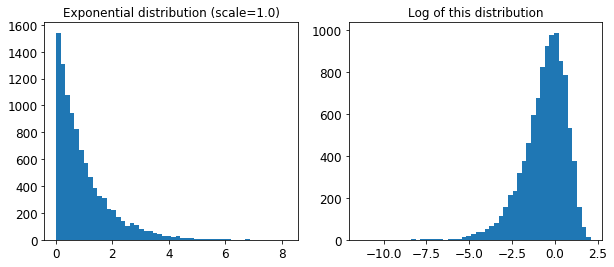

In [125]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

La distribución que usamos para `C` parece bastante diferente: la escala de las muestras se toma de una distribución uniforme dentro de un rango dado, por lo que el gráfico correcto, que representa el registro de las muestras, se ve aproximadamente constante. Esta distribución es útil cuando no tienes idea de cuál es la escala objetivo:

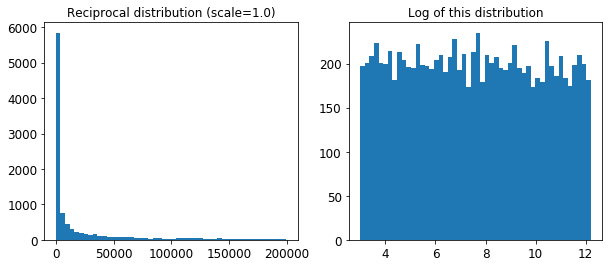

In [126]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

La distribución recíproca es útil cuando no tiene idea de cuál debería ser la escala del hiperparámetro (de hecho, como podemos ver en la figura de la derecha, todas las escalas son igualmente probables, dentro del rango dado), mientras que la distribución exponencial es la mejor cuando sepamos (más o menos) cuál debe ser la escala del hiperparámetro.

## Ej.3

**Prueba a añadir un transformador en el pipeline de preparación para seleccionar sólo los atributos más importantes**

In [127]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Vamos a definir el número de características principales que queremos mantener:

In [128]:
k = 5

Ahora veamos los índices de las mejores k características:

In [129]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12], dtype=int64)

In [130]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

Vamos a comprobar que estas son las mejores características de k:

In [131]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude')]

Tiene buena pinta ... Ahora vamos a crear un nuev pipeline que ejecute el pipeline de preparación previamente definido y agregue la selección de las mejores k características:

In [132]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [133]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Veamos las característica de las tres primeras instancias

In [134]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Ahora vamos a verificar que estas son las mejores k características:

In [135]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

## Ej.4

**Prueba a añadir un único pipeline que haga la preparación completa de los datos más la predicción final**

In [136]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [137]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

Probemos el pipeline completo en algunas instancias:

In [138]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predicciones:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Etiquetas:\t\t", list(some_labels))

Predicciones:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Etiquetas:		 [286600.0, 340600.0, 196900.0, 46300.0]


Bueno, el pipeline completo parece funcionar bien. Por supuesto, las predicciones no son fantásticas: serían mejores si utilizáramos el mejor `RandomForestRegressor` que encontramos anteriormente, en lugar del mejor `SVR`.

## Ej.5

**Explorar automáticamente algunas opciones de preparación utilizando `GridSearchCV`.**

In [139]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=16)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
c:\program files\python37\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   14.4s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  3.2min
[Parallel(n_jobs=16)]: Done 240 out of 240 | elapsed:  8.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=16,
       param_grid=[{'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [140]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

La mejor estrategia de imputación es `most_frequent` y, al parecer, casi todas las funciones son útiles (15 de 16). El último (ISLAND) parece añadir un poco de ruido.